In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
import torch
torch.cuda.is_available()

True

## 資料準備 : 詳細介紹可參考NLP第一階段課程Day20,21

In [3]:
all_data=[]
paths =[r'spam_data/spam', r'spam_data/easy_ham', r'spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)
all_data

array([['[ILUG] Garden Ornaments | mvcmv', '1'],
       ['Play a Hilarious Phone Prank', '1'],
       ['[ILUG-Social] Poker for money againts real players', '1'],
       ...,
       ['CNET NEWS.COM: Jobs touts OS X, iPods, iMac', '0'],
       ['New Sony Vaio: When small becomes TOO small [ANCHORDESK]', '0'],
       ['Your Daily Dilbert 07/11/2002', '0']], dtype='<U109')

In [4]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [5]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
                 

[nltk_data] Downloading package stopwords to /home/ckchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
X = clean_content(X)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

In [8]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [9]:
x_train.shape

(2738, 1500)

In [10]:
np.unique(y_train)

array([0, 1], dtype=uint8)

### 判斷是否有GPU可以使用

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 模型搭建

In [12]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [13]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [14]:
model = Model(input_dimention=1500,output_classes=2).to(device)

In [15]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 1500])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])


In [16]:
batch_size = 4
input_features = 1500#要和input_dimention一樣
dummy_input = torch.randn(batch_size, input_features).to(device)


In [17]:
output = model(dummy_input)
print(output)

tensor([[-0.5339, -0.1745],
        [-0.1870,  0.5267],
        [-0.1977, -0.1708],
        [ 0.3251, -0.6613]], device='cuda:0', grad_fn=<AddmmBackward>)


## Loss

#### classification

In [18]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [19]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [20]:
criterion = CrossEntropyLoss()

## optimizer

In [21]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [22]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [23]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [24]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

### 訓練

In [25]:
from tqdm import tqdm 

In [26]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in tqdm(range(epochs)):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


  2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

epoch : 0
目前 train loss : 0.43
目前 test loss : 0.35
目前 test accuracy : 0.86


  6%|▌         | 3/50 [00:03<00:51,  1.09s/it]

epoch : 2
目前 train loss : 0.32
目前 test loss : 0.26
目前 test accuracy : 0.91


 10%|█         | 5/50 [00:05<00:49,  1.10s/it]

epoch : 4
目前 train loss : 0.26
目前 test loss : 0.22
目前 test accuracy : 0.92


 14%|█▍        | 7/50 [00:07<00:47,  1.10s/it]

epoch : 6
目前 train loss : 0.24
目前 test loss : 0.20
目前 test accuracy : 0.92


 18%|█▊        | 9/50 [00:09<00:44,  1.09s/it]

epoch : 8
目前 train loss : 0.24
目前 test loss : 0.22
目前 test accuracy : 0.92


 22%|██▏       | 11/50 [00:11<00:42,  1.08s/it]

epoch : 10
目前 train loss : 0.20
目前 test loss : 0.22
目前 test accuracy : 0.92


 26%|██▌       | 13/50 [00:14<00:39,  1.08s/it]

epoch : 12
目前 train loss : 0.19
目前 test loss : 0.24
目前 test accuracy : 0.91


 30%|███       | 15/50 [00:16<00:37,  1.07s/it]

epoch : 14
目前 train loss : 0.20
目前 test loss : 0.20
目前 test accuracy : 0.92


 34%|███▍      | 17/50 [00:18<00:35,  1.07s/it]

epoch : 16
目前 train loss : 0.20
目前 test loss : 0.21
目前 test accuracy : 0.92


 38%|███▊      | 19/50 [00:20<00:33,  1.08s/it]

epoch : 18
目前 train loss : 0.20
目前 test loss : 0.20
目前 test accuracy : 0.92


 42%|████▏     | 21/50 [00:22<00:31,  1.08s/it]

epoch : 20
目前 train loss : 0.19
目前 test loss : 0.20
目前 test accuracy : 0.92


 46%|████▌     | 23/50 [00:24<00:29,  1.08s/it]

epoch : 22
目前 train loss : 0.18
目前 test loss : 0.19
目前 test accuracy : 0.93


 50%|█████     | 25/50 [00:27<00:26,  1.08s/it]

epoch : 24
目前 train loss : 0.16
目前 test loss : 0.27
目前 test accuracy : 0.91


 54%|█████▍    | 27/50 [00:29<00:24,  1.08s/it]

epoch : 26
目前 train loss : 0.18
目前 test loss : 0.20
目前 test accuracy : 0.92


 58%|█████▊    | 29/50 [00:31<00:22,  1.09s/it]

epoch : 28
目前 train loss : 0.17
目前 test loss : 0.22
目前 test accuracy : 0.92


 62%|██████▏   | 31/50 [00:33<00:20,  1.10s/it]

epoch : 30
目前 train loss : 0.17
目前 test loss : 0.20
目前 test accuracy : 0.92


 66%|██████▌   | 33/50 [00:35<00:18,  1.10s/it]

epoch : 32
目前 train loss : 0.17
目前 test loss : 0.22
目前 test accuracy : 0.92


 70%|███████   | 35/50 [00:38<00:16,  1.10s/it]

epoch : 34
目前 train loss : 0.14
目前 test loss : 0.21
目前 test accuracy : 0.92


 74%|███████▍  | 37/50 [00:40<00:14,  1.10s/it]

epoch : 36
目前 train loss : 0.16
目前 test loss : 0.25
目前 test accuracy : 0.92


 78%|███████▊  | 39/50 [00:42<00:12,  1.11s/it]

epoch : 38
目前 train loss : 0.16
目前 test loss : 0.21
目前 test accuracy : 0.92


 82%|████████▏ | 41/50 [00:44<00:09,  1.10s/it]

epoch : 40
目前 train loss : 0.15
目前 test loss : 0.23
目前 test accuracy : 0.92


 86%|████████▌ | 43/50 [00:46<00:07,  1.09s/it]

epoch : 42
目前 train loss : 0.16
目前 test loss : 0.21
目前 test accuracy : 0.92


 90%|█████████ | 45/50 [00:49<00:05,  1.09s/it]

epoch : 44
目前 train loss : 0.16
目前 test loss : 0.22
目前 test accuracy : 0.92


 94%|█████████▍| 47/50 [00:51<00:03,  1.09s/it]

epoch : 46
目前 train loss : 0.14
目前 test loss : 0.23
目前 test accuracy : 0.92


 98%|█████████▊| 49/50 [00:53<00:01,  1.08s/it]

epoch : 48
目前 train loss : 0.15
目前 test loss : 0.25
目前 test accuracy : 0.91


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [27]:
print(classification_report(prediction,y_test_numpy))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       576
           1       0.73      0.66      0.70       109

    accuracy                           0.91       685
   macro avg       0.84      0.81      0.82       685
weighted avg       0.90      0.91      0.91       685



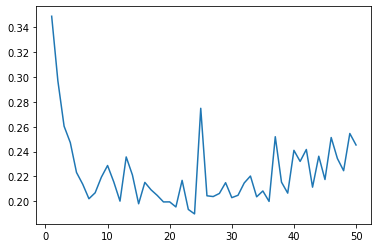

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

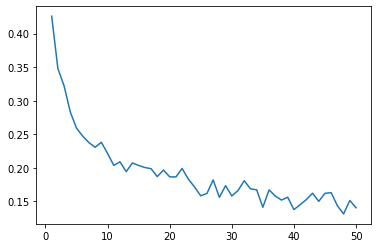

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [30]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)

### 載入 

In [31]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content=cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
